In [1]:
#initialization
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import shuffle
from pipeline import reading, explore, preprocess, features, classify
from imp import reload
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.learning_curve import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    precision_recall_curve, average_precision_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

reload(classify)
filename = 'pipeline/data/tothepipe_II.csv'
filecheck = 'pipeline/data/tothecheck_II.csv'
label = 'outcome_val'

In [2]:
df = reading.read(filename)

In [3]:
# Which are the features available to train our model?
explore.basics(df)

Observations:
567

164 features:
    1) Unnamed: 0
    2) Unnamed: 0.1
    3) Year of signing
    4) Month of signing
    5) fiscal_year
    6) major_sector
    7) procurement_category
    8) procurement_method
    9) procurement_type
    10) product_line
    11) project_name
    12) region
    13) supplier_country
    14) resolved_supplier
    15) borrower_country_std
    16) ppp
    17) currency_convert
    18) amount_of_contract (constant USD)
    19) amount_of contract (PPP)
    20) project_total_amount (PPP)
    21) contract as proportion of project
    22) country_mean_amount
    23) contract_high_rel__mean_by_year_flag
    24) country_total_amount
    25) contract_proportion__total_by_year
    26) objective
    27) competitive
    28) allegation_category
    29) outcome_val
    30) resolved_supplier_sum
    31) resolved_supplier_mean
    32) resolved_supplier_std
    33) resolved_supplier_sum_project
    34) resolved_supplier_mean_project
    35) resolved_supplier_std_project
  

In [4]:
#Notice the large values in some of the columns, might be useful to turn into log(x)
explore.desc_statistics(df)

Descriptive statistics:
              Unnamed: 0  Unnamed: 0.1  Year of signing  Month of signing  \
count         567.000000    567.000000       567.000000        567.000000   
mean          283.000000    520.227513      2008.761905          6.985891   
std           163.823075    372.562328         3.238150          3.201669   
min             0.000000      1.000000      2001.000000          1.000000   
25%           141.500000    200.500000      2007.000000          4.000000   
50%           283.000000    482.000000      2009.000000          7.000000   
75%           424.500000    726.500000      2012.000000         10.000000   
max           566.000000   1322.000000      2014.000000         12.000000   
median        283.000000    482.000000      2009.000000          7.000000   
skew            0.000000      0.643274        -0.475514         -0.208880   
kurtosis       -1.200000     -0.739026        -0.588628         -1.092021   
missing_vals    0.000000      0.000000         0.000

In [5]:
# check for nulls in the dataset
for name in df.columns:
    if df[name].isnull().values.any():
        print(name)

objective
competitive
resolved_supplier_std
resolved_supplier_std_project
project_name_std
project_name_std_project


In [6]:
# if there are any nulls in "objective" and "competitive" columns, go for the conservative side and tag as False
have_nulls = ['objective','competitive']
for ft in have_nulls:
    df[ft] = df[ft].fillna('False')

# if there are any nulls in "xx_std" columns, means that there is only one observation, so assign standard deviation 
# of 1
std_nulls = ['resolved_supplier_std','resolved_supplier_std_project', 'project_name_std', 'project_name_std_project']
for ft in std_nulls:
    df[ft] = df[ft].fillna(0)

In [7]:
# turn booleans into 1's and 0's
have_bools = ['objective','competitive', 'contract_high_rel__mean_by_year_flag']
for ft in have_bools:
    df[ft] = df[ft].apply(lambda x: 1 if x else 0)

df['outcome_val'] = df['outcome_val'].apply(lambda x: 1 if x == 2 else 0)

In [8]:
df['outcome_val'].sum()

177

In [9]:
# For all features with categorical data, create integers referring to such values. This is in contrast to creating
# binary variables for all the possible values of these features. Notice that regression won't be as interpretable with
# this transformation, but methods such as decision trees and random forests might benefit from this categorization
# vs a binarization.
lb = preprocessing.LabelEncoder()
names = ['major_sector', 'product_line','region', 'supplier_country', 'resolved_supplier', 'borrower_country_std',\
         'allegation_category', 'procurement_type', 'procurement_method', 'procurement_category']
for name in names:
    keys = list(set(df[name].values))
    keys.sort()
    lb = preprocessing.LabelEncoder()
    lb.fit(keys)
    temp = lb.transform(df[name].values)
    df['{}_int'.format(name)] = temp
    df = df.drop(name, 1)

In [10]:
#delete unnecessary column
df = df.drop('project_name', 1)
df = df.drop('Unnamed: 0', 1)
df = df.drop('Unnamed: 0.1', 1)
df = df.drop('allegation_category_int', 1)

In [11]:
# Transform features with very large integers using natural logarithm
names_w_large_nums = ['country_mean_amount', 'amount_of_contract (constant USD)', 'amount_of contract (PPP)', \
                      'project_total_amount (PPP)', 'country_total_amount']
for ft in names_w_large_nums:
    df[ft + " log"] = df[ft].apply(lambda x: math.log(x))
    df = df.drop(ft, 1)

In [12]:
#check new list of available features
fts = list(df.keys())
for i in range(len(fts)):
    if fts[i] == label:
        fts.pop(i)
        break
fts

['Year of signing',
 'Month of signing',
 'fiscal_year',
 'ppp',
 'currency_convert',
 'contract as proportion of project',
 'contract_high_rel__mean_by_year_flag',
 'contract_proportion__total_by_year',
 'objective',
 'competitive',
 'resolved_supplier_sum',
 'resolved_supplier_mean',
 'resolved_supplier_std',
 'resolved_supplier_sum_project',
 'resolved_supplier_mean_project',
 'resolved_supplier_std_project',
 'project_name_sum',
 'project_name_mean',
 'project_name_std',
 'project_name_sum_project',
 'project_name_mean_project',
 'project_name_std_project',
 'amount_of contract (PPP)+larger_average',
 'project_total_amount (PPP)+larger_average',
 'resolved_supplier_sum+larger_average',
 'resolved_supplier_sum_project+larger_average',
 'by_borrower_country_std_amount',
 'by_sector_amount',
 'by_year_amount',
 'by_cat_amount',
 'by_meth_amount',
 'by_type_amount',
 'by_borrower_country_std_resolved_supplier',
 'by_sector_resolved_supplier',
 'by_year_resolved_supplier',
 'by_cat_reso

In [13]:
# Sort by year/month of contract, in order to later split train/test correctly
df.sort_values(['Year of signing', 'Month of signing'], inplace=True)
df.reset_index(inplace=True)
df.head(10), df.tail(10)

(   index  Year of signing  Month of signing  fiscal_year       ppp  \
 0     30             2001                 5         2001  1.694059   
 1     31             2001                 5         2001  1.694059   
 2     32             2001                 5         2001  1.694059   
 3     33             2001                 5         2001  1.694059   
 4     34             2001                 5         2001  1.694059   
 5     35             2001                 5         2001  1.694059   
 6     36             2001                 5         2001  1.694059   
 7     37             2001                 5         2001  1.694059   
 8     38             2001                 5         2001  1.694059   
 9     39             2002                 7         2003  2.315613   
 
    currency_convert  contract as proportion of project  \
 0                11                               0.01   
 1                11                               0.01   
 2                11                    

In [14]:
# Take up to Jun/12
first_80_len = round(len(df) * 0.8) - 1
first_80_len, len(df) - first_80_len

(453, 114)

In [15]:
#delete year and month
for i in range(len(fts)):
    if fts[i] == 'Year of signing':
        fts.pop(i)
        break
for i in range(len(fts)):
    if fts[i] == 'Month of signing':
        fts.pop(i)
        break
for i in range(len(fts)):
    if fts[i] == 'fiscal_year':
        fts.pop(i)
        break
fts

['ppp',
 'currency_convert',
 'contract as proportion of project',
 'contract_high_rel__mean_by_year_flag',
 'contract_proportion__total_by_year',
 'objective',
 'competitive',
 'resolved_supplier_sum',
 'resolved_supplier_mean',
 'resolved_supplier_std',
 'resolved_supplier_sum_project',
 'resolved_supplier_mean_project',
 'resolved_supplier_std_project',
 'project_name_sum',
 'project_name_mean',
 'project_name_std',
 'project_name_sum_project',
 'project_name_mean_project',
 'project_name_std_project',
 'amount_of contract (PPP)+larger_average',
 'project_total_amount (PPP)+larger_average',
 'resolved_supplier_sum+larger_average',
 'resolved_supplier_sum_project+larger_average',
 'by_borrower_country_std_amount',
 'by_sector_amount',
 'by_year_amount',
 'by_cat_amount',
 'by_meth_amount',
 'by_type_amount',
 'by_borrower_country_std_resolved_supplier',
 'by_sector_resolved_supplier',
 'by_year_resolved_supplier',
 'by_cat_resolved_supplier',
 'by_meth_resolved_supplier',
 'by_type_r

In [16]:
xtrain = df.ix[:first_80_len - 1, fts]
ytrain = df.ix[:first_80_len - 1, label]
xtest = df.ix[first_80_len:, fts]
ytest = df.ix[first_80_len:, label]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((453, 156), (453,), (114, 156), (114,))

In [17]:
# Define the set of models to be used in the loop, as well as a set of metrics to be recorded for every model.
#models = ['DT']
models = ['LR', 'KNN', 'DT', 'SVM', 'RF', 'GB']
#models = ['LR', 'KNN', 'DT', 'SVM', 'GB']
metrics = ['precision', 'recall', 'roc_auc', 'f1']

#classifiers
classifiers = {'LR': LogisticRegression(),'KNN': KNeighborsClassifier(),'DT': DecisionTreeClassifier(),\
'SVM': LinearSVC(),'RF': RandomForestClassifier(),'GB': GradientBoostingClassifier()}

In [18]:
len(fts)

156

In [19]:
feats = {}
for i in range(100):
    x = [i for i in fts]
    shuffle(x)
    # Reduce the number of features with a linear SVC
    lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(xtrain[x], ytrain)
    model = SelectFromModel(lsvc, threshold='mean', prefit=True)
    X = model.transform(xtrain)
    X.shape
    # Chosen features:
    ft_temp = []
    i=0
    for name in xtrain.columns:
        if pd.DataFrame(model.inverse_transform(X))[i].sum() != 0 :
            ft_temp.append(name)
        i += 1
    for i in ft_temp:
        if i not in feats:
            feats[i]=0
        feats[i] += 1
feats

{'Agriculture, fishing, and forestry': 19,
 'Agriculture, fishing, and forestryresolved_supplierpercentage': 17,
 'Civil Works': 20,
 'Civil Worksborrower_country_stdpercentage': 14,
 'Civil Worksfiscal_yearpercentage': 16,
 'Civil Worksmajor_sectorpercentage': 23,
 'Civil Worksresolved_supplierpercentage': 12,
 'Consultant Services': 15,
 'Consultant Servicesborrower_country_stdpercentage': 18,
 'Consultant Servicesfiscal_yearpercentage': 30,
 'Consultant Servicesmajor_sectorpercentage': 13,
 'Consultant Servicesresolved_supplierpercentage': 18,
 'Direct Contracting': 15,
 'Direct Contractingborrower_country_stdpercentage': 20,
 'Direct Contractingfiscal_yearpercentage': 15,
 'Direct Contractingmajor_sectorpercentage': 13,
 'Direct Contractingresolved_supplierpercentage': 18,
 'Education': 21,
 'Educationresolved_supplierpercentage': 17,
 'Energy and mining': 18,
 'Energy and miningresolved_supplierpercentage': 17,
 'Goods': 20,
 'Goodsborrower_country_stdpercentage': 17,
 'Goodsfisca

In [20]:
import operator
min_times = 20
fts = []
for feat, val in sorted(feats.items(), key=operator.itemgetter(1), reverse=True):
    if val > min_times:
        fts.append(feat)
fts.append('amount_of_contract (constant USD) log')
sorted(fts), len(fts)

(['Civil Worksmajor_sectorpercentage',
  'Consultant Servicesfiscal_yearpercentage',
  'Education',
  'Goodsresolved_supplierpercentage',
  'International Competitive Biddingfiscal_yearpercentage',
  'Limited International Biddingmajor_sectorpercentage',
  'Quality And Cost-Based Selection',
  'Shoppingborrower_country_stdpercentage',
  'Single Source Selection',
  'Single Source Selectionmajor_sectorpercentage',
  'Transportation',
  'amount_of_contract (constant USD) log',
  'atomization+sector+contract',
  'contract_high_rel__mean_by_year_flag',
  'country_mean_amount log',
  'currency_convert',
  'diversification_resolved_supplier_country',
  'diversification_resolved_supplier_major_sector',
  'procurement_category_int',
  'project_name_std',
  'rate_resolved_supplier_total',
  'resolved_supplier_different_borrower_country_std',
  'resolved_supplier_sum+larger_average'],
 23)

In [21]:
fts

['Consultant Servicesfiscal_yearpercentage',
 'resolved_supplier_different_borrower_country_std',
 'diversification_resolved_supplier_country',
 'Shoppingborrower_country_stdpercentage',
 'diversification_resolved_supplier_major_sector',
 'country_mean_amount log',
 'rate_resolved_supplier_total',
 'Single Source Selectionmajor_sectorpercentage',
 'Limited International Biddingmajor_sectorpercentage',
 'currency_convert',
 'Civil Worksmajor_sectorpercentage',
 'Single Source Selection',
 'resolved_supplier_sum+larger_average',
 'Transportation',
 'Quality And Cost-Based Selection',
 'contract_high_rel__mean_by_year_flag',
 'International Competitive Biddingfiscal_yearpercentage',
 'Education',
 'procurement_category_int',
 'project_name_std',
 'atomization+sector+contract',
 'Goodsresolved_supplierpercentage',
 'amount_of_contract (constant USD) log']

In [22]:
# Classifier threshold
u = 0.95
# thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
iters = 3
# top number of contracts
top_perc = 0.2

In [23]:
all_models = classify.classify(xtrain[fts], ytrain, models, iters, u, metrics, top_perc)

LR
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
437    0
436    0
129    1
130    1
381    0
384    0
141    1
299    0
304    0
199    0
143    0
369    1
347    0
400    0
344    0
345    0
237    0
Name: y, dtype: int64
0.0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
203    0
202    0
438    0
435    0
379    0
380    0
429    0
359    0
358    0
140    1
302    0
301    0
303    0
286    0
368    0
369    1
346    0
289    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
412    1
130    1
405    1
310    1
227    0
391    1
390    0
358    0
140    1
301    0
322    1
185    0
245    0
244    0
201    0
143    0
348    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
128    1
130    1
302    0
301    0
419    0
133    0
187    0
287    1
245    0
143    0
348    0
399    0
357    0
432    1
217    0
218    0
233    0
180    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
372    1
390    0
389    0
392    0
393    0
359    0
358    0
300    0
188    0
134    0
185    0
245    0
369    1
347    0
346    0
288    0
400    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
414    1
437    0
310    1
389    0
394    1
300    0
304 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
412    1
437    0
129    1
404    1
177    1
426    1
424    1
392    0
393    0
411    0
141    1
358    0
322    1
187    0
286    0
289    0
355    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
383    0
145    1
415    1
413    1
412    1
437    0
172    0
389    0
390    0
394    1
372    1
386    0
358    0
303    0
302    0
304    0
420    0
287    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
414    1
415    1
389    0
391    1
359    0
227    0
417    0
424    1
425    1
420    0
144    0
346    0
288    0
432    1
357    0
356    0
179    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
130    1
228    0
226    0
310    1
302    0
393    0
385    0
24     0
131    0
136    0
420    0
187    0
286    0
245    0
369    1
348    0
289    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
203    0
413    1
414    1
415    1
435    0
128    1
228 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
145    1
203    0
415    1
310    1
344    0
386    0
429    0
360    1
243    0
244    0
286    0
199    0
200    0
143    0
420    0
299    0
361    0
347    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
383    0
427    1
430    1
413    1
412    1
195    1
384    0
429    0
140    1
358    0
372    1
390    0
357    0
381    0
399    0
200    0
369    1
279    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
412    1
435    0
127    1
372    1
385    0
384    0
227    0
359    0
300    0
419    0
186    0
245    0
199    0
348    0
356    0
357    0
361    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
130    1
381    0
385    0
226    0
360    1
304    0
303    0
420    0
186    0
132    0
244    0
143    0
288    0
289    0
343    0
356    0
362    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
228    0
310    1
372    1
379    0
411    0
389 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
383    0
382    0
452    1
424    1
427    1
422    1
170    0
195    1
194    1
122    0
343    0
128    1
417    0
416    0
186    0
141    1
188    0
160    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
383    0
452    1
425    1
19     1
194    1
111    0
386    0
414    1
345    0
344    0
356    0
357    0
186    0
185    0
188    0
288    0
362    0
249    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
20     0
425    1
427    1
195    1
430    1
194    1
202    0
129    1
385    0
384    0
414    1
412    1
187    0
356    0
140    1
162    0
362    0
260    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
203    0
202    0
435    0
372    1
429    0
359    0
140    1
228    0
416    0
302    0
300    0
188    0
420    0
185    0
286    0
143    0
369    1
289    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
412    1
128    1
227    0
22     0
303    0
300 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
383    0
202    0
275    1
22     0
431    1
417    0
145    1
404    1
276    1
367    0
369    1
355    0
176    1
438    0
394    1
245    0
326    1
407    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
129    1
141    1
23     1
280    1
372    1
277    1
188    0
368    0
367    0
411    0
176    1
394    1
327    1
414    1
412    1
421    0
357    0
355    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
129    1
424    1
177    1
416    0
430    1
359    0
169    1
389    0
195    1
176    1
19     1
414    1
355    0
432    1
437    0
396    0
161    0
187    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
414    1
127    1
405    1
24     0
226    0
301    0
300    0
391    1
386    0
141    1
134    0
136    0
20     0
419    0
418    0
369    1
142    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
414    1
127    1
383    0
382    0
452    1
177 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
404    1
405    1
383    0
260    1
175    1
261    1
388    1
425    1
424    1
182    1
374    1
430    1
431    1
329    1
328    1
331    1
213    1
241    1
Name: y, dtype: int64
1.0


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
452    1
22     0
292    1
140    1
141    1
253    1
328    1
426    1
147    1
336    1
411    0
280    1
276    1
367    0
391    1
170    0
339    0
364    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
429    0
411    0
417    0
202    0
422    1
21     1
24     0
447    1
184    1
182    1
424    1
425    1
332    1
253    1
252    1
329    1
395    1
279    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
438    0
372    1
226    0
380    0
393    0
386    0
429    0
358    0
359    0
144    0
369    1
288    0
399    0
345    0
281    0
432    1
237    0
235    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
415    1
414    1
437    0
127    1
128    1
227    0
379    0
389    0
394    1
393    0
384    0
359    0
140    1
304    0
301    0
345    0
287    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
438    0
405    1
389    0
384    0
226    0
360 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1]
24     0
22     0
21     1
259    1
428    0
175    1
261    1
292    1
253    1
285    1
388    1
414    1
241    1
329    1
330    1
406    1
19     1
194    1
Name: y, dtype: int64
0.8
[1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1]
382    0
383    0
424    1
427    1
425    1
205    1
195    1
175    1
255    1
254    1
213    1
326    1
327    1
452    1
140    1
241    1
147    1
335    1
Name: y, dtype: int64
0.846153846154
[1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0]
404    1
260    1
429    0
382    0
195    1
422    1
285    1
327    1
146    1
333    1
332    1
424    1
427    1
431    1
330    1
20     0
203    0
389    0
Name: y, dtype: int64
1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
228    0
391    1
302    0
299    0
386    0
417    0
416    0
131    0
188    0
185    0
245    0
368    0
143    0
343    0
236    0
234    0
233    0
351    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
437    0
227    0
381    0
393    0
38

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0]
203    0
216    1
261    1
184    1
176    1
252    1
209    0
336    1
397    0
396    0
422    1
22     0
145    1
426    1
435    0
436    0
437    0
180    0
Name: y, dtype: int64
1.0
[1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
260    1
411    0
216    1
202    0
336    1
427    1
426    1
398    0
195    1
356    0
334    1
23     1
311    0
413    1
415    1
246    0
247    0
279    1
Name: y, dtype: int64
1.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
412    1
130    1
405    1
422    1
280    1
370    1
276    1
452    1
145    1
307    1
448    1
449    1
215    1
261    1
262    1
204    1
182    1
433    1
Name: y, dtype: int64
1.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0]
415    1
127    1
404    1
140    1
278    1
170    0
307    1
424    1
215    1
216    1
375    1
292    1
434    1
214    1
411    0
335    1
390    0
339    0
Name: y, dtype: int64
0.933333333333
[1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
414    1
404    1
203    0
202    0
450    1
17

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
414    1
129    1
389    0
390    0
140    1
337    1
279    1
260    1
177    1
444    1
424    1
104    0
216    1
215    1
292    1
184    1
147    1
333    1
Name: y, dtype: int64
0.833333333333
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
413    1
128    1
127    1
394    1
389    0
186    0
178    0
383    0
246    0
452    1
365    0
314    0
424    1
397    0
208    0
108    0
430    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
435    0
436    0
437    0
128    1
343    0
432    1
289    0
55     0
424    1
427    1
150    0
398    0
384    0
386    0
385    0
429    0
375    1
295    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
412    1
129    1
405    1
372    1
344    0
243    0
290    0
386    0
141    1
185    0
365    0
356    0
323    0
424    1
149    0
398    0
247    0
Name: y, dtype: int64
0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
128    1
358    0
359    0
140    1
280    1
37

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
438    0
437    0
130    1
411    0
393    0
343    0
209    0
115    0
117    0
373    1
148    0
398    0
428    0
334    1
140    1
200    0
201    0
123    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
391    1
344    0
345    0
386    0
385    0
429    0
140    1
417    0
307    1
186    0
187    0
243    0
315    1
288    0
323    0
398    0
406    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
414    1
127    1
392    0
343    0
364    0
365    0
289    0
325    0
425    1
424    1
150    0
386    0
385    0
140    1
188    0
185    0
375    1
Name: y, dtype: int64
0.0
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0]
412    1
130    1
450    1
280    1
172    0
446    1
309    1
177    1
427    1
292    1
184    1
175    1
255    1
146    1
147    1
330    1
341    0
389    0
Name: y, dtype: int64
0.875
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
412    1
450    1
278    1
190    1
24     0
172    0
17

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
438    0
404    1
389    0
393    0
343    0
209    0
382    0
56     0
117    0
373    1
427    1
105    1
398    0
397    0
294    0
433    1
120    0
Name: y, dtype: int64
0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
127    1
370    1
279    1
426    1
425    1
20     0
216    1
374    1
175    1
182    1
181    1
434    1
285    1
430    1
326    1
332    1
333    1
329    1
Name: y, dtype: int64
0.944444444444
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
358    0
359    0
286    0
422    1
370    1
260    1
451    1
309    1
448    1
427    1
104    0
145    1
254    1
182    1
433    1
214    1
213    1
388    1
Name: y, dtype: int64
0.764705882353
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
414    1
127    1
404    1
280    1
447    1
452    1
427    1
425    1
104    0
338    0
339    0
216    1
262    1
291    1
184    1
204    1
255    1
181    1
Name: y, dtype: int64
0.833333333333
Finished running KNN
DT
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
3

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
261    1
262    1
291    1
184    1
176    1
182    1
252    1
387    1
242    1
330    1
202    0
413    1
414    1
436    0
437    0
130    1
360    1
358    0
Name: y, dtype: int64
1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
130    1
360    1
141    1
188    0
186    0
407    0
277    1
279    1
22     0
145    1
365    0
170    0
70     1
428    0
423    1
334    1
205    1
333    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
128    1
404    1
392    0
359    0
417    0
416    0
185    0
143    0
345    0
344    0
279    1
190    1
23     1
452    1
21     1
172    0
117    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
405    1
392    0
390    0
360    1
429    0
416    0
417    0
322    1
432    1
422    1
447    1
23     1
171    1
172    0
364    0
206    0
396    0
339    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
405    1
227    0
411    0
390    0
394    1
429    0
188 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
404    1
411    0
389    0
390    0
394    1
369    1
432    1
278    1
23     1
452    1
22     0
117    0
314    0
70     1
20     0
176    1
305    0
395    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
345    0
343    0
383    0
22     0
451    1
170    0
426    1
195    1
121    0
109    0
127    1
130    1
227    0
226    0
310    1
390    0
385    0
359    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
438    0
127    1
129    1
128    1
130    1
393    0
243    0
142    0
289    0
355    0
432    1
209    0
366    1
55     0
145    1
365    0
259    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
438    0
385    0
358    0
429    0
417    0
186    0
369    1
278    1
383    0
309    1
307    1
206    0
395    1
430    1
387    1
333    1
342    1
408    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
23     1
382    0
171    1
20     0
111    0
438    0
436 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
280    1
278    1
373    1
309    1
375    1
374    1
261    1
204    1
176    1
254    1
213    1
327    1
202    0
359    0
322    1
24     0
23     1
365    0
Name: y, dtype: int64
1.0
[1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0]
412    1
415    1
172    0
203    0
202    0
215    1
291    1
205    1
182    1
181    1
431    1
429    0
416    0
329    1
277    1
190    1
22     0
425    1
Name: y, dtype: int64
0.9
[1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0]
414    1
141    1
188    0
452    1
426    1
428    0
334    1
255    1
395    1
327    1
105    1
444    1
445    1
329    1
331    1
341    0
241    1
389    0
Name: y, dtype: int64
0.769230769231
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
130    1
424    1
216    1
374    1
262    1
291    1
183    1
181    1
328    1
330    1
411    0
389    0
391    1
393    0
443    1
322    1
410    0
447    1
Name: y, dtype: int64
1.0
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
439    1
452    1
426    1
425    1
291    1
18

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

0.0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
275    1
23     1
169    1
353    0
228    0
303    0
302    0
304    0
133    0
236    0
240    0
239    0
229    0
231    0
222    0
224    0
266    0
139    0
Name: y, dtype: int64
0.166666666667
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
202    0
372    1
119    0
104    0
364    0
70     1
334    1
162    0
204    1
159    0
315    1
309    1
142    0
143    0
245    0
244    0
333    1
Name: y, dtype: int64
0.0
[1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0]
160    0
435    0
436    0
437    0
0      0
415    1
31     0
32     0
167    0
4      0
330    1
191    0
192    0
69     0
9      0
245    0
18     1
440    0
Name: y, dtype: int64
0.1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
21     1
170    0
136    0
349    0
352    0
132    0
229    0
230    0
270    0
271    0
273    0
281    0
439    1
66     0
54     0
145    1
407    0
322    1
Name: y, dtype: int64
0.222222222222
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
128    1
310    1
307    1
308  

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
438    0
437    0
129    1
393    0
385    0
360    1
322    1
367    0
447    1
382    0
421    0
22     0
172    0
365    0
424    1
70     1
204    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
387    1
129    1
204    1
205    1
374    1
413    1
259    1
417    0
432    1
216    1
262    1
184    1
183    1
278    1
279    1
277    1
382    0
70     1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
205    1
387    1
388    1
331    1
413    1
438    0
436    0
130    1
382    0
262    1
182    1
181    1
425    1
253    1
392    0
326    1
327    1
384    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
425    1
392    0
416    0
432    1
383    0
141    1
414    1
322    1
280    1
430    1
436    0
385    0
398    0
338    0
334    1
395    1
314    0
175    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
436    0
130    1
385    0
360    1
188    0
186 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
386    0
384    0
141    1
186    0
187    0
22     0
172    0
170    0
427    1
425    1
204    1
330    1
342    1
409    1
128    1
405    1
404    1
228    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
127    1
130    1
405    1
404    1
411    0
358    0
140    1
368    0
369    1
177    1
24     0
383    0
382    0
22     0
315    1
427    1
428    0
18     1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
438    0
437    0
411    0
391    1
360    1
185    0
187    0
367    0
368    0
432    1
279    1
383    0
206    0
426    1
425    1
195    1
205    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
435    0
390    0
358    0
360    1
414    1
415    1
278    1
322    1
384    0
22     0
171    1
177    1
428    0
365    0
338    0
205    1
334    1
395    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
416    0
404    1
385    0
277    1
279    1
190    1
427 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
425    1
427    1
190    1
22     0
21     1
18     1
395    1
129    1
205    1
415    1
414    1
391    1
369    1
408    0
365    0
423    1
334    1
227    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
140    1
392    0
393    0
424    1
385    0
407    0
275    1
145    1
309    1
204    1
387    1
333    1
305    0
315    1
326    1
245    0
244    0
Name: y, dtype: int64
0.0
[1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0]
216    1
254    1
434    1
253    1
252    1
430    1
128    1
331    1
411    0
141    1
369    1
177    1
412    1
383    0
22     0
426    1
427    1
424    1
Name: y, dtype: int64
1.0
[1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0]
412    1
280    1
209    0
276    1
278    1
190    1
425    1
213    1
431    1
265    0
263    0
442    0
336    1
398    0
429    0
174    1
173    0
216    1
Name: y, dtype: int64
0.9
[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
170    0
184    1
204    1
147    1
332    1
128    1
130 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0]
259    1
278    1
382    0
383    0
254    1
181    1
431    1
177    1
242    1
129    1
414    1
330    1
388    1
195    1
447    1
307    1
392    0
322    1
Name: y, dtype: int64
1.0
[0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0]
414    1
130    1
170    0
259    1
145    1
172    0
22     0
216    1
425    1
424    1
183    1
292    1
175    1
176    1
284    1
327    1
330    1
428    0
Name: y, dtype: int64
0.8
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1]
435    0
437    0
436    0
287    1
276    1
308    1
173    0
18     1
261    1
262    1
183    1
205    1
175    1
213    1
382    0
420    0
427    1
242    1
Name: y, dtype: int64
0.733333333333
[1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0]
260    1
127    1
128    1
129    1
422    1
452    1
145    1
215    1
375    1
374    1
426    1
175    1
255    1
322    1
367    0
327    1
20     0
407    0
Name: y, dtype: int64
1.0
[1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0]
447    1
277    1
278    1
367    0
414    1
43

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
427    1
140    1
280    1
278    1
204    1
292    1
252    1
175    1
405    1
214    1
333    1
329    1
331    1
375    1
275    1
195    1
394    1
392    0
Name: y, dtype: int64
1.0
[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
127    1
414    1
280    1
277    1
424    1
427    1
327    1
276    1
332    1
451    1
184    1
181    1
252    1
253    1
390    0
411    0
214    1
375    1
Name: y, dtype: int64
1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
279    1
412    1
452    1
130    1
205    1
204    1
425    1
184    1
181    1
284    1
285    1
24     0
253    1
252    1
336    1
335    1
214    1
213    1
Name: y, dtype: int64
0.0
[0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0]
415    1
275    1
422    1
130    1
375    1
374    1
205    1
176    1
252    1
213    1
390    0
195    1
331    1
430    1
431    1
171    1
172    0
23     1
Name: y, dtype: int64
1.0
[1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0]
140    1
18     1
216    1
215    1
374    1
334    1
292 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
205    1
260    1
328    1
330    1
216    1
375    1
254    1
182    1
253    1
214    1
146    1
405    1
360    1
322    1
369    1
422    1
177    1
407    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
331    1
330    1
216    1
374    1
261    1
262    1
291    1
255    1
327    1
404    1
405    1
336    1
389    0
359    0
186    0
368    0
432    1
190    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
438    0
128    1
391    1
358    0
140    1
419    0
407    0
279    1
276    1
374    1
261    1
452    1
184    1
171    1
450    1
365    0
175    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
412    1
414    1
24     0
280    1
276    1
372    1
411    0
389    0
386    0
141    1
172    0
145    1
365    0
216    1
307    1
322    1
261    1
187    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
435    0
141    1
209    0
24     0
185    0
314    0
405 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
429    0
140    1
291    1
292    1
184    1
205    1
181    1
253    1
214    1
127    1
277    1
278    1
326    1
435    0
388    1
335    1
177    1
170    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
291    1
182    1
285    1
252    1
412    1
214    1
242    1
147    1
145    1
329    1
330    1
24     0
23     1
130    1
278    1
451    1
372    1
394    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
435    0
129    1
130    1
404    1
405    1
429    0
140    1
141    1
417    0
450    1
280    1
446    1
397    0
382    0
291    1
205    1
204    1
176    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
127    1
209    0
260    1
314    0
145    1
425    1
390    0
228    0
358    0
359    0
261    1
262    1
304    0
299    0
182    1
284    1
285    1
252    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
436    0
276    1
190    1
382    0
383    0
172    0
373 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
414    1
259    1
278    1
261    1
204    1
292    1
255    1
284    1
252    1
242    1
335    1
404    1
405    1
145    1
21     1
439    1
340    1
395    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
415    1
129    1
140    1
260    1
314    0
276    1
451    1
20     0
448    1
449    1
261    1
291    1
183    1
181    1
338    0
340    1
339    0
433    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
414    1
129    1
307    1
260    1
445    1
216    1
427    1
204    1
205    1
252    1
387    1
241    1
242    1
332    1
331    1
314    0
392    0
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
413    1
439    1
140    1
130    1
259    1
309    1
308    1
175    1
202    0
188    0
284    1
214    1
411    0
427    1
332    1
329    1
407    0
423    1
Name: y, dtype: int64
0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
259    1
374    1
291    1
184    1
214    1
327    1
147 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
22     0
275    1
415    1
438    0
24     0
416    0
425    1
292    1
284    1
146    1
335    1
336    1
18     1
279    1
190    1
169    1
372    1
309    1
Name: y, dtype: int64
0.0
[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
260    1
387    1
182    1
330    1
429    0
404    1
447    1
412    1
414    1
438    0
422    1
452    1
177    1
360    1
358    0
426    1
424    1
367    0
Name: y, dtype: int64
1.0
[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
254    1
332    1
252    1
329    1
411    0
214    1
407    0
169    1
426    1
188    0
279    1
365    0
364    0
405    1
415    1
412    1
433    1
394    1
Name: y, dtype: int64
1.0
[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
422    1
22     0
405    1
435    0
436    0
387    1
184    1
331    1
252    1
416    0
424    1
374    1
214    1
407    0
336    1
392    0
389    0
360    1
Name: y, dtype: int64
1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
130    1
404    1
450    1
372    1
389    0
393    0
422 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
405    1
276    1
279    1
183    1
181    1
253    1
329    1
434    1
177    1
423    1
438    0
389    0
203    0
171    1
367    0
340    1
339    0
443    1
Name: y, dtype: int64
1.0
[0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0]
414    1
422    1
276    1
425    1
426    1
188    0
254    1
404    1
182    1
181    1
451    1
214    1
326    1
327    1
447    1
444    1
446    1
307    1
Name: y, dtype: int64
1.0
[0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 0]
129    1
127    1
259    1
432    1
24     0
425    1
22     0
255    1
448    1
284    1
252    1
431    1
242    1
335    1
332    1
329    1
331    1
367    0
Name: y, dtype: int64
1.0
[0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1]
130    1
177    1
404    1
422    1
278    1
276    1
260    1
259    1
424    1
291    1
292    1
216    1
255    1
327    1
252    1
214    1
387    1
329    1
Name: y, dtype: int64
1.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
202    0
203    0
429    0
417    0
416    0
275    1
260 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
rv, best_models, bm = classify.select_best_models(all_models, models, 'precision_top_n')

SVM {"{'C': 1}": {'precision': 0.18974358974358974, 'roc_auc': 0.49945054945054945, 'time': 0.026840051015218098, 'recall': 0.2271062271062271, 'precision_top_n': 0.1074074074074074, 'f1': 0.18417424869037768}, "{'C': 0.1}": {'precision': 0.092592592592592601, 'roc_auc': 0.49402006172839502, 'time': 0.026797294616699219, 'recall': 0.12345679012345678, 'precision_top_n': 0.055555555555555552, 'f1': 0.10582010582010583}}
LR {"{'penalty': 'l2', 'C': 0.001}": {'precision': 0.0, 'roc_auc': 0.5, 'time': 0.014465649922688803, 'recall': 0.0, 'precision_top_n': 0.0, 'f1': 0.0}, "{'penalty': 'l2', 'C': 10}": {'precision': 0.0, 'roc_auc': 0.5, 'time': 0.0059826374053955078, 'recall': 0.0, 'precision_top_n': 0.0, 'f1': 0.0}, "{'penalty': 'l1', 'C': 10}": {'precision': 0.31005291005291008, 'roc_auc': 0.50082663029864449, 'time': 0.55683565139770508, 'recall': 0.1400867760799849, 'precision_top_n': 0.88205128205128203, 'f1': 0.18645885704709234}, "{'penalty': 'l1', 'C': 1e-05}": {'precision': 0.0, '

In [25]:
all_models

{'DT': {"{'max_depth': 1, 'criterion': 'entropy', 'min_samples_split': 10, 'max_features': 'log2'}": {'f1': 0.051948051948051945,
   'precision': 0.088888888888888892,
   'precision_top_n': 0.66666666666666663,
   'recall': 0.036714975845410627,
   'roc_auc': 0.46897626002170884,
   'time': 0.0063459873199462891},
  "{'max_depth': 1, 'criterion': 'entropy', 'min_samples_split': 10, 'max_features': 'sqrt'}": {'f1': 0.0,
   'precision': 0.0,
   'precision_top_n': 0.0,
   'recall': 0.0,
   'roc_auc': 0.5,
   'time': 0.0078625679016113281},
  "{'max_depth': 1, 'criterion': 'entropy', 'min_samples_split': 2, 'max_features': 'log2'}": {'f1': 0.0,
   'precision': 0.0,
   'precision_top_n': 0.0,
   'recall': 0.0,
   'roc_auc': 0.5,
   'time': 0.005484263102213542},
  "{'max_depth': 1, 'criterion': 'entropy', 'min_samples_split': 2, 'max_features': 'sqrt'}": {'f1': 0.051282051282051273,
   'precision': 0.1111111111111111,
   'precision_top_n': 0.33333333333333331,
   'recall': 0.033333333333333

In [26]:
best_models

{'DT': {'metrics': {'f1': 0.09926478202340272,
   'precision': 0.16666666666666666,
   'precision_top_n': 1.0,
   'recall': 0.073122529644268783,
   'roc_auc': 0.4804018445322793,
   'time': 0.006518046061197917},
  'parameters': "{'max_depth': 5, 'criterion': 'gini', 'min_samples_split': 5, 'max_features': 'log2'}"},
 'GB': {'metrics': {'f1': 0.057239057239057235,
   'precision': 0.12169312169312169,
   'precision_top_n': 1.0,
   'recall': 0.03751187084520418,
   'roc_auc': 0.46819300082894716,
   'time': 0.013470808664957682},
  'parameters': "{'subsample': 1.0, 'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 10}"},
 'KNN': {'metrics': {'f1': 0.070175438596491238,
   'precision': 0.16666666666666666,
   'precision_top_n': 1.0,
   'recall': 0.044444444444444446,
   'roc_auc': 0.4902416891601315,
   'time': 0.006395975748697917},
  'parameters': "{'weights': 'uniform', 'algorithm': 'auto', 'n_neighbors': 10}"},
 'LR': {'metrics': {'f1': 0.18645885704709234,
   'precision': 0.3100

In [32]:
name = 'RF'
params = best_models[name]['parameters']
name, params

('RF',
 "{'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'n_estimators': 10}")

In [33]:
# check if best model effectively performs well using the testing data
clf = classifiers[name]
clf.set_params(**eval(best_models[name]['parameters']))
if hasattr(clf, 'predict_proba'):
    yscores = clf.fit(xtrain[fts], ytrain).predict_proba(xtest[fts])[:,1]
else:
    yscores = clf.fit(xtrain[fts], ytrain).decision_function(xtest[fts])
xtest_temp = xtest.copy()
xtest_temp['yscore'] = yscores
xtest_temp['expected_value'] = xtest_temp['yscore'] * xtest_temp['amount_of_contract (constant USD) log']
xtest_temp = xtest_temp.sort_values(by='expected_value', ascending=False)

In [34]:
perc = 0.2
n = round(ytest.size * perc)
threshold = 0.95
yhat = np.asarray([1 if i >= threshold else 0 for i in xtest_temp['yscore']])
mtrs = classify.evaluate_classifier(ytest, yhat)
mtrs['precision_top_n'] = precision_score(ytest[:n], yhat[:n])

In [35]:
mtrs

{'accuracy': 0.5,
 'f1': 0.12307692307692307,
 'precision': 0.5,
 'precision_top_n': 0.5,
 'recall': 0.070175438596491224,
 'roc_auc': 0.5}

In [36]:
# baseline for accuracy
ytest[ytest == 1].count() / len(ytest) 

0.5

In [37]:
precision, recall, _ = precision_recall_curve(ytest, yscores)

In [38]:
average_precision = average_precision_score(ytest, yscores)

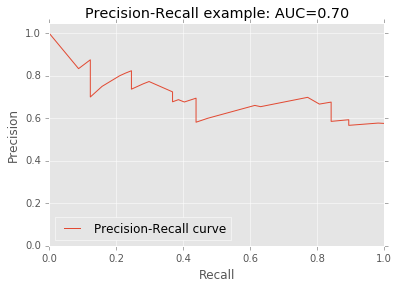

In [39]:
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()

SVM
LR
KNN
RF
DT
GB


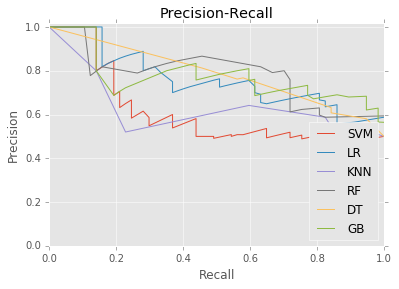

In [53]:
# For all classifiers on best_models
plt.clf()

for name, clf in classifiers.items():
    try:
        clf.set_params(**eval(best_models[name]['parameters']))
        print(name)
        if hasattr(clf, 'predict_proba'):
            yscores = clf.fit(xtrain[fts], ytrain).predict_proba(xtest[fts])[:,1]
        else:
            yscores = clf.fit(xtrain[fts], ytrain).decision_function(xtest[fts])
        precision, recall, _ = precision_recall_curve(ytest, yscores)
        plt.plot(recall, precision, label=name)
    except:
        pass

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.02])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower right")

Test on unlabeled data

In [84]:
check = reading.read(filecheck)

In [85]:
# if there are any nulls in "objective" and "competitive" columns, go for the conservative side and tag as False
for ft in have_nulls:
    check[ft] = check[ft].fillna('False')

# if there are any nulls in "xx_std" columns, means that there is only one observation, so assign standard deviation 
# of 1
for ft in std_nulls:
    check[ft] = check[ft].fillna(0)

# turn booleans into 1's and 0's
for ft in have_bools:
    check[ft] = check[ft].apply(lambda x: 1 if x else 0)
    
for name in names:
    keys = list(set(check[name].values))
    keys.sort()
    lb = preprocessing.LabelEncoder()
    lb.fit(keys)
    temp = lb.transform(check[name].values)
    check['{}_int'.format(name)] = temp
    check = check.drop(name, 1)

for ft in names_w_large_nums:
    check[ft + " log"] = check[ft].apply(lambda x: math.log(x))
    check = check.drop(ft, 1)

In [89]:
# check if best model effectively performs well using the testing data
name = 'RF'
params = best_models[name]['parameters']
clf = classifiers[name]
clf.set_params(**eval(best_models[name]['parameters']))
if hasattr(clf, 'predict_proba'):
    yscores = clf.fit(xtrain[fts], ytrain).predict_proba(check[fts])[:,1]
else:
    yscores = clf.fit(xtrain[fts], ytrain).decision_function(check[fts])
xtest_temp = check.copy()
xtest_temp['yscore'] = yscores
xtest_temp['expected_value'] = xtest_temp['yscore'] * xtest_temp['amount_of_contract (constant USD) log']
xtest_temp = xtest_temp.sort_values(by='expected_value', ascending=False)
perc = 0.2
n = round(ytest.size * perc)
threshold = 0.95
yhat = np.asarray([1 if i >= threshold else 0 for i in xtest_temp['yscore']])
yhat.sum(), yhat.size, yhat.sum()/yhat.size

(2, 356, 0.0056179775280898875)

In [90]:
xtest_temp.to_csv("prioritized.csv")

In [ ]:
### END OF NOTEBOOK